In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

PLOTTING

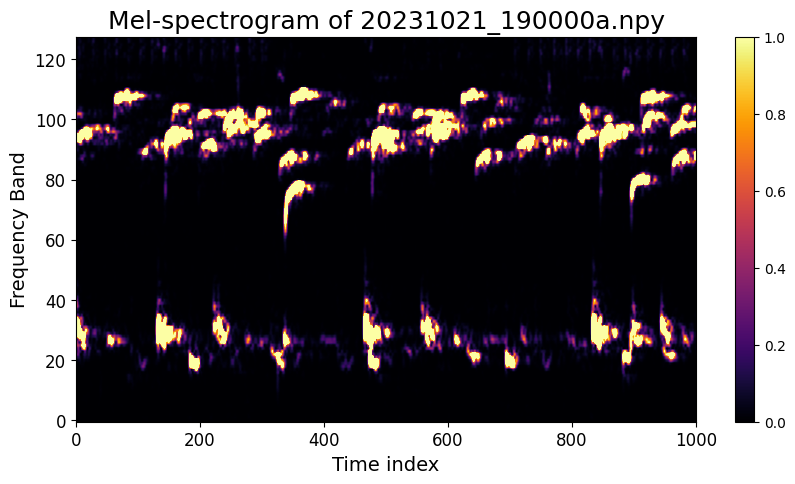

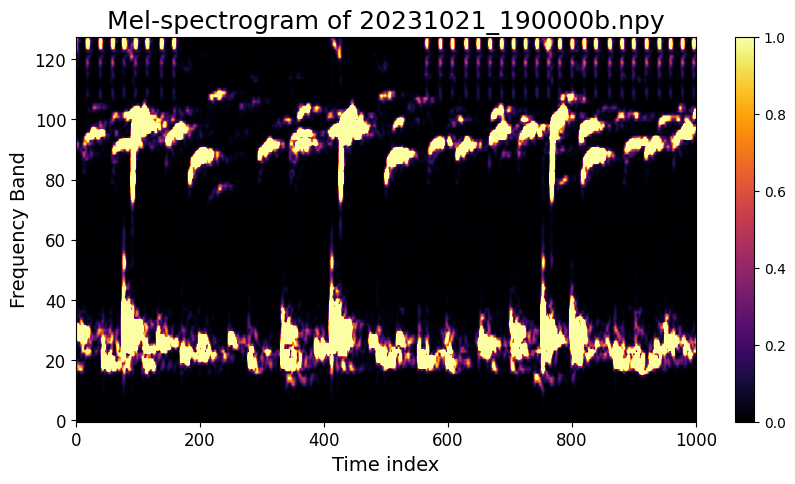

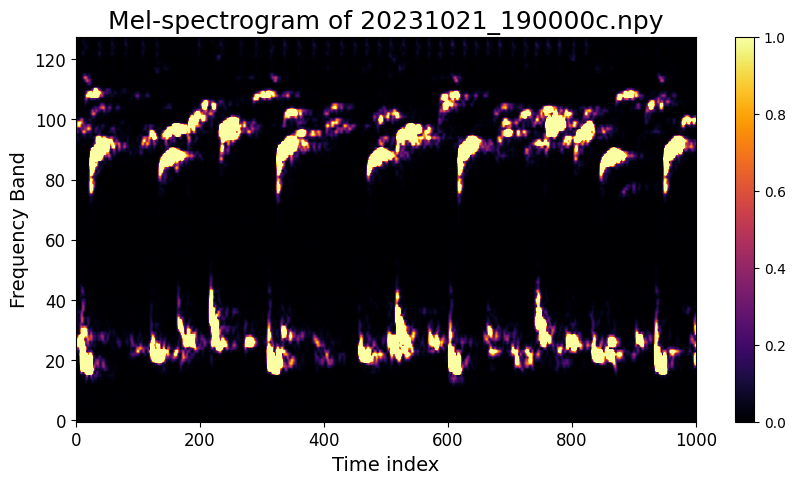

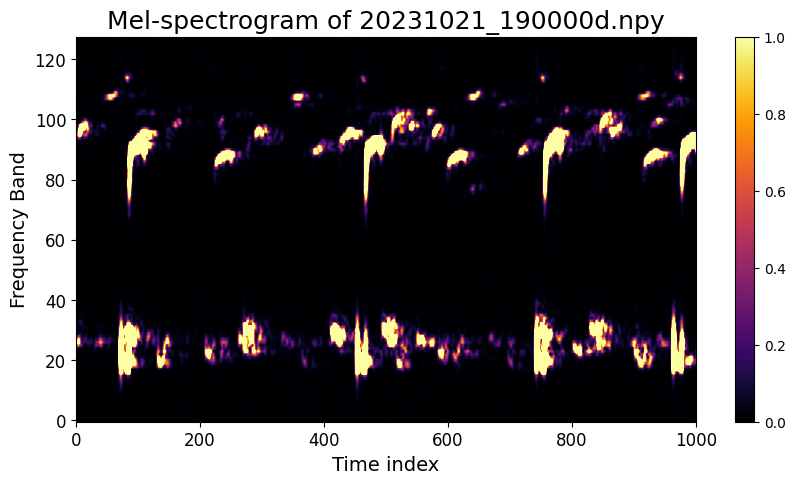

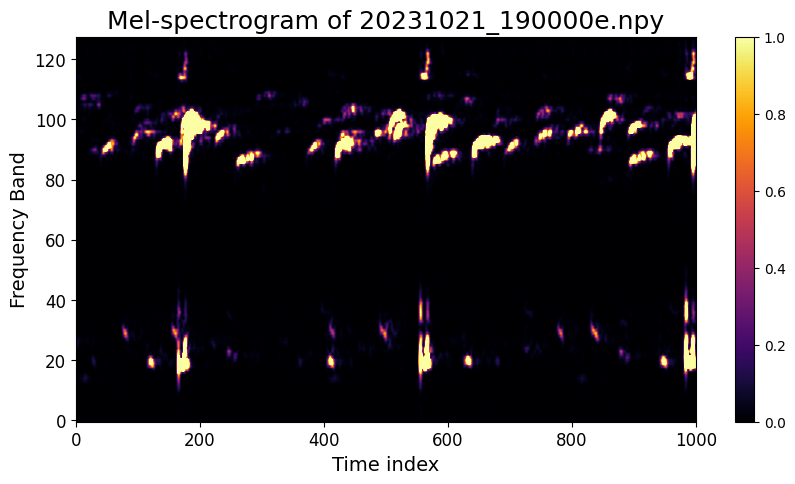

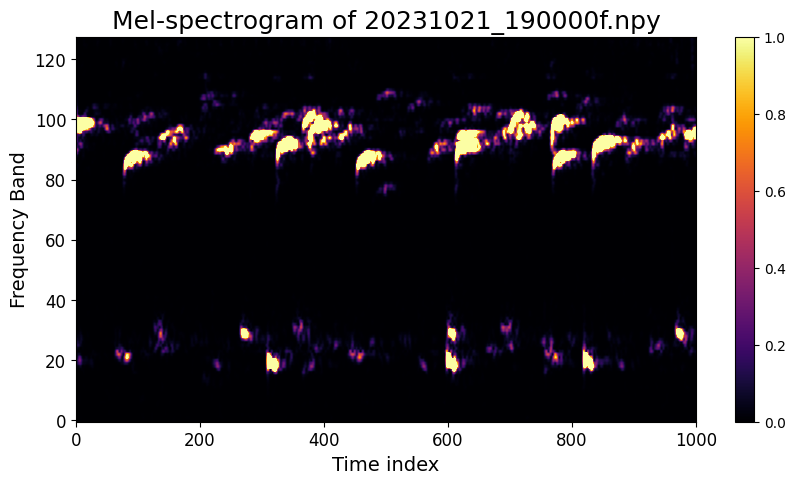

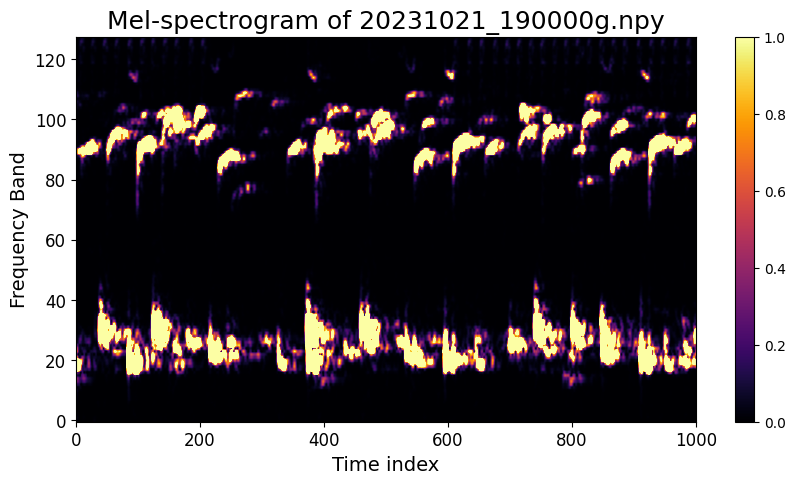

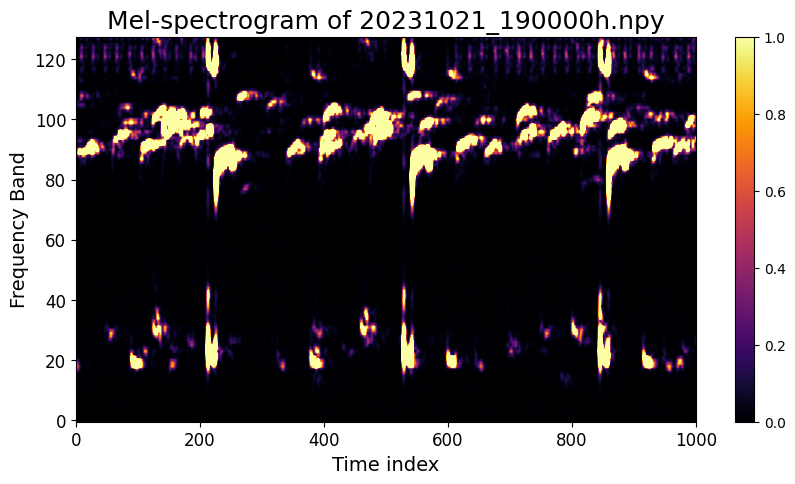

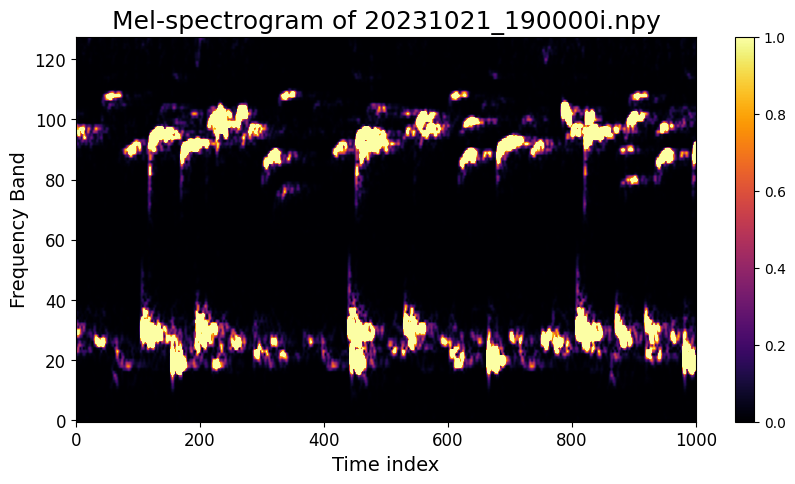

In [2]:
def plot_mel_spectrogram_graph_from_matrix(
    data_source_path: str,
    vmin_energy_scale: float = 0,
    vmax_energy_scale: float = 1,
    xlim_left: int = 0,
    xlim_right: int = 1000,
) -> None:
    """
    Generates and displays mel-spectrogram graphs from .npy files in the specified directory.
    Parameters:
    data_source_path (str): Path to the directory containing .npy files with mel-spectrogram data.
    vmin_energy_scale (float, optional): Minimum energy scale for the color mapping. Default is 0.
    vmax_energy_scale (float, optional): Maximum energy scale for the color mapping. Default is 1.
    xlim_left (int, optional): Left limit for the x-axis. Default is 0.
    xlim_right (int, optional): Right limit for the x-axis. Default is 1000.
    Returns:
    None
    """

    files = [f for f in os.listdir(data_source_path) if f.endswith(".npy")]

    for file in files:
        data = np.load(os.path.join(data_source_path, file))

        fig, ax = plt.subplots(figsize=(10, 5))

        cax = ax.imshow(data, aspect="auto", cmap="inferno", origin="lower")

        cax.set_clim(vmin=vmin_energy_scale, vmax=vmax_energy_scale)

        fig.colorbar(cax)

        ax.set_xlabel('Time index', fontsize=14)
        
        ax.set_ylabel('Frequency Band', fontsize=14)

        ax.set_title(f"Mel-spectrogram of {file}", fontsize=18)

        ax.tick_params(axis='both', which='major', labelsize=12)  

        ax.set_xlim([xlim_left, xlim_right])

        plt.show()


plot_mel_spectrogram_graph_from_matrix(
    data_source_path="../data/not_aligned/all",
    vmin_energy_scale=0,
    vmax_energy_scale=1,
    xlim_left=0,
    xlim_right=1000,
)

In [ ]:
import os
import librosa
import numpy as np

PROCESSING

In [ ]:
def process_block(
    y_block: list,
    sr: int = 96000,
    n_fft: int = 6096,
    hop_length: int = 512,
    n_mels: int = 128,
    f_min: int = 1600,
    f_max: int = 4096,
) -> np.ndarray:
    """
    Processes a block of audio data to compute its Mel spectrogram in decibels.
    Parameters:
    y_block (numpy.ndarray): Audio time series.
    sr (int): Sampling rate of `y_block`.
    n_fft (int): Length of the FFT window.
    hop_length (int): Number of samples between successive frames.
    n_mels (int): Number of Mel bands to generate.
    f_min (float): Lowest frequency (in Hz).
    f_max (float): Highest frequency (in Hz).
    Returns:
    numpy.ndarray: Mel spectrogram in decibels.
    """

    S = librosa.feature.melspectrogram(
        y=y_block,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=f_min,
        fmax=f_max,
    )
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [ ]:
def get_mel_spectrogram_from_audio(
    input_directory: str,
    output_directory: str,
    block_duration: str = 10,
    sr: int = 96000,
    n_fft: int = 6096,
    hop_length: int = 512,
    n_mels: int = 128,
    f_min: int = 1600,
    f_max: int = 4096,
) -> None:
    """
    Processes audio files in the input directory, computes their mel spectrograms,
    and saves them as .npy files in the output directory.
    Parameters:
    -----------
    input_directory : str
        Path to the directory containing input audio files.
    output_directory : str
        Path to the directory where the output .npy files will be saved.
    sr : int, optional
        Sampling rate for loading audio files. Default is 96000.
    block_duration : int, optional
        Duration of each block in seconds for processing the audio. Default is 10.
    n_fft : int, optional
        Number of FFT components. Default is 6096.
    hop_length : int, optional
        Number of samples between successive frames. Default is 512.
    n_mels : int, optional
        Number of Mel bands to generate. Default is 128.
    f_min : int, optional
        Lowest frequency (in Hz). Default is 1600.
    f_max : int, optional
        Highest frequency (in Hz). Default is 4096.
    Returns:
    --------
    None
    """

    os.makedirs(output_directory, exist_ok=True)

    for filename in os.listdir(input_directory):
        if filename.endswith(".WAV"):
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(
                output_directory, filename.replace(".WAV", ".npy")
            )

            mel_spectrogram_accum = None

            y, sr = librosa.load(input_path, sr=sr)
            total_samples = len(y)
            block_size = block_duration * sr

            for start in range(0, total_samples, block_size):
                end = min(start + block_size, total_samples)
                y_block = y[start:end]

                S_dB_block = process_block(
                    y_block=y_block,
                    sr=sr,
                    n_fft=n_fft,
                    hop_length=hop_length,
                    n_mels=n_mels,
                    f_min=f_min,
                    f_max=f_max,
                )

                if mel_spectrogram_accum is None:
                    mel_spectrogram_accum = S_dB_block
                else:
                    mel_spectrogram_accum = np.hstack(
                        (mel_spectrogram_accum, S_dB_block)
                    )

            np.save(output_path, mel_spectrogram_accum)


In [ ]:
hop_length = 512
n_fft = 6096
n_mels = 128
f_min = 1600
f_max = 4096
sr = 96000
block_duration = 10

input_directory = "../data/not_aligned/audios"
output_directory = "../data/not_aligned/para_comparar"

get_mel_spectrogram_from_audio(
    input_directory=input_directory, output_directory=output_directory
)